# topic modelling

In [5]:
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
from gensim import corpora, models
import spacy
import matplotlib.pyplot as plt
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
import os
from collections import Counter

target_column = 'body'

# Download NLTK data
nltk.download('stopwords')
stop_words = nlp.Defaults.stop_words

# Load data
df = pd.read_csv("/Users/sriyan/Documents/is434-ubisoft/data-collection/reddit/data scraping/data/reddit_ubisoft_external_posts.csv",encoding='iso-8859-1')
texts = df[target_column].astype(str).tolist()




 

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sriyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# Initialize spaCy
nlp = spacy.load('en_core_web_sm')
# Cleaning function
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www.\S+', '', text)
    text = re.sub(r'@\w+|#\w+', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

cleaned_texts = [clean_text(text) for text in texts]

# Tokenization and Lemmatization
def tokenize_lemmatize(text):
    doc = nlp(text)
    return [token.lemma_ for token in doc if token.is_alpha and token.lemma_ not in stop_words]

tokenized_texts = [tokenize_lemmatize(text) for text in cleaned_texts]

# Assuming 'tokenized_texts' is your list of tokenized tweets
all_words = [word for text in tokenized_texts for word in text]
word_freq = Counter(all_words)
print(word_freq.most_common(20))

[('I', 7182), ('game', 3044), ('ubisoft', 1840), ('s', 1393), ('t', 1113), ('play', 1038), ('like', 954), ('account', 670), ('time', 666), ('try', 524), ('know', 515), ('m', 505), ('new', 486), ('want', 485), ('think', 435), ('use', 389), ('ac', 383), ('buy', 379), ('steam', 378), ('connect', 366)]


In [ ]:
from gensim.models import CoherenceModel
custom_stopwords = {'ubisoft', 'game', 'go', 'get', 'I'}

stop_words = set(stopwords.words('english'))
stop_words.update(custom_stopwords)



# Create Dictionary and Corpus
dictionary = corpora.Dictionary(tokenized_texts)
dictionary.filter_extremes(no_below=15, no_above=0.5)
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

# Build LDA Model
max_topics = 100
step = 10
for num_topics in range(10, max_topics+step, step):
    print(f"Number of Topics: {num_topics}")
    num_topics = 10
    passes = 15
    random_state = 42

    lda_model = models.LdaMulticore(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        random_state=random_state,
        # update_every=1,
        chunksize=100,
        passes=passes,
        # alpha='auto',
        workers=4,
        per_word_topics=True
    )
    
    

    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model_lda.get_coherence()
    print(f'Coherence Score: {coherence_score}')
    
    perplexity = lda_model.log_perplexity(corpus)
    print(f'Perplexity: {perplexity}')

    # Print Topics
    for idx, topic in lda_model.print_topics(-1):
        print(f"Topic: {idx}\nWords: {topic}\n")

    # Visualize Topics
    lda_vis = gensimvis.prepare(lda_model, corpus, dictionary)
    # Uncomment the line below to display the visualization in the notebook
    # pyLDAvis.display(data=lda_vis)
    pyLDAvis.save_html(lda_vis, f'reddit_external_lda_visualization_topic_{num_topics}.html')

In [ ]:
pyLDAvis.display(lda_vis)

# Sentiment Analysis

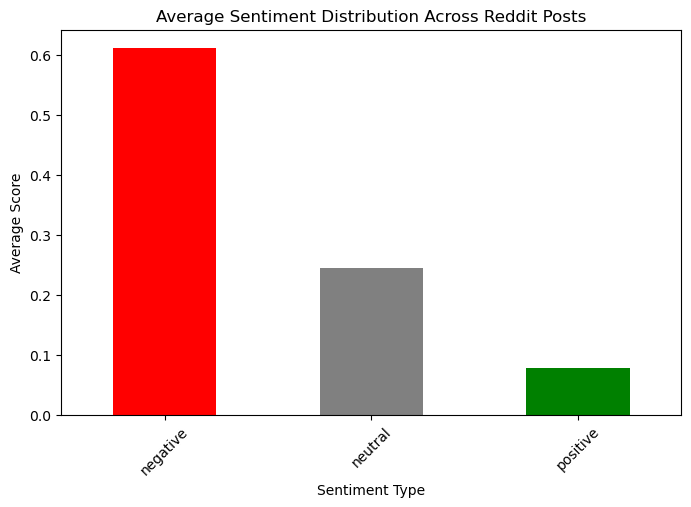

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your data (assuming it's already read into raw_reddit_df)
# raw_reddit_df = pd.read_csv('your_data_file.csv')  # Uncomment and modify if loading the data

# Summarizing sentiment distribution
sentiment_counts = df[['negative', 'neutral', 'positive']].mean()

# Creating a bar chart for sentiment distribution
plt.figure(figsize=(8, 5))
sentiment_counts.plot(kind='bar', color=['red', 'gray', 'green'])
plt.title('Average Sentiment Distribution Across Reddit Posts')
plt.xlabel('Sentiment Type')
plt.ylabel('Average Score')
plt.xticks(rotation=45)
plt.show()


<Figure size 1400x800 with 0 Axes>

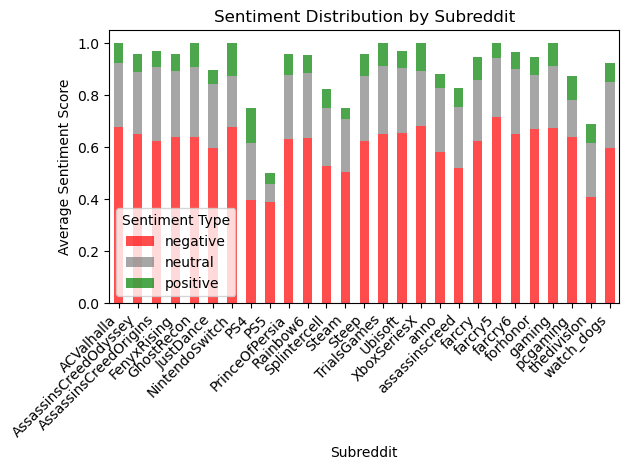

In [ ]:
# grouping senitiments by subreddits
sentiment_per_subreddit = df.groupby('subreddit')[['negative', 'neutral', 'positive']].mean()

plt.figure(figsize=(14, 8))
sentiment_per_subreddit.plot(kind='bar', stacked=True, color=['red', 'gray', 'green'], alpha=0.7)
plt.title('Sentiment Distribution by Subreddit')
plt.xlabel('Subreddit')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=45, ha='right', fontsize=10)  # Adjusting rotation and alignment for better readability
plt.legend(title="Sentiment Type")
plt.tight_layout()
plt.show()



/var/folders/wk/27zdp1q12l9dx34w5ml48nrw0000gn/T/ipykernel_767/875846937.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date_created'] = pd.to_datetime(df['date_created'], errors='coerce', dayfirst=True)


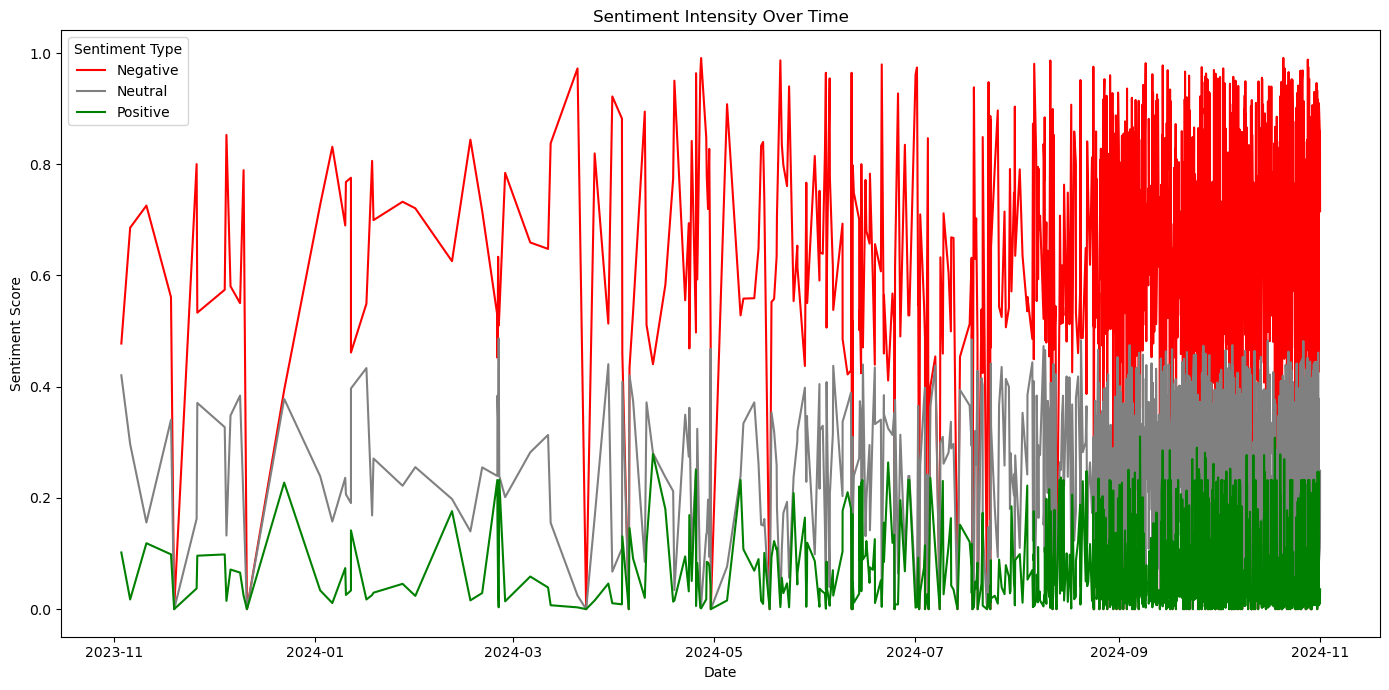

In [ ]:
# Converting 'date_created' to datetime format for plotting over time
df['date_created'] = pd.to_datetime(df['date_created'], errors='coerce', dayfirst=True)
time_sorted_df = df.sort_values(by='date_created')

plt.figure(figsize=(14, 7))
plt.plot(time_sorted_df['date_created'], time_sorted_df['negative'], color='red', label='Negative')
plt.plot(time_sorted_df['date_created'], time_sorted_df['neutral'], color='gray', label='Neutral')
plt.plot(time_sorted_df['date_created'], time_sorted_df['positive'], color='green', label='Positive')
plt.title('Sentiment Intensity Over Time')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.legend(title="Sentiment Type")
plt.tight_layout()
plt.show()



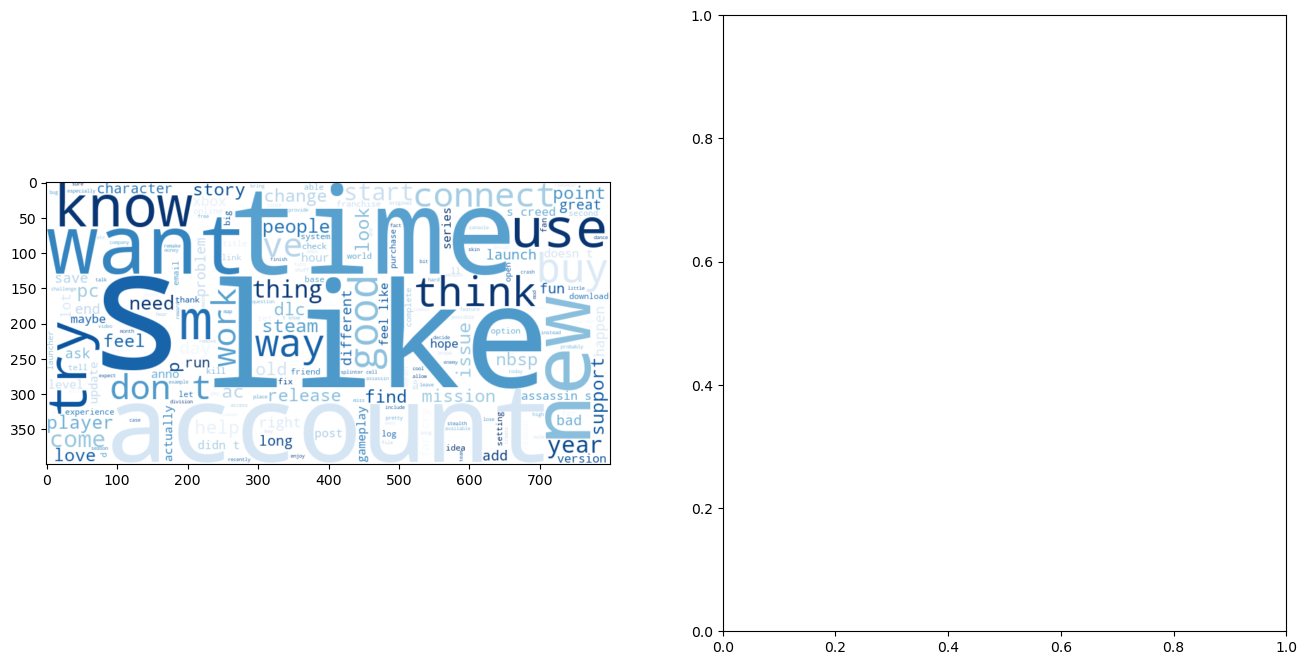

In [12]:
from wordcloud import WordCloud

# Filtering and cleaning posts for positive and negative sentiments
all_texts = df['body'].dropna().astype(str).tolist()
cleaned_texts = [clean_text(text) for text in all_texts]
tokenised_texts = [tokenize_lemmatize(text) for text in cleaned_texts]
all_posts = ' '.join([' '.join(text) for text in tokenised_texts])

stopwords = {'game', 'ubisoft', 'games', 'ubi', 'Ubisoft', 'I', 'play'}

# Generating word clouds for positive and negative posts with custom stopwords
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
all_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Blues', stopwords=stopwords).generate(all_posts)

axes[0].imshow(all_wordcloud, interpolation='bilinear')

plt.show()